# Model Development

- Train/Test Split > Tuning > Cross Verification > Training > Testing > Model Saved
- Traing Loss and Training AUC Plot and Test ROC plot

In [ ]:
# combined_gcn_pipeline_optuna_cv.py
import os
import json
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, matthews_corrcoef,
    cohen_kappa_score, brier_score_loss, confusion_matrix,
    precision_score, f1_score, roc_curve
)
import matplotlib.pyplot as plt
import optuna

# Ensure output directory
output_dir = 'GCN_results' # apr_4
os.makedirs(output_dir, exist_ok=True)

# Expanded atom features
def atom_features(atom):
    return torch.tensor([
        # Basic properties
        atom.GetAtomicNum(),                     # Atomic number
        atom.GetDegree(),                        # Number of bonded neighbors
        atom.GetFormalCharge(),                  # Formal charge
        atom.GetNumRadicalElectrons(),           # Number of radical electrons
        int(atom.GetIsAromatic()),               # Aromaticity flag
        
        # Extended properties
        atom.GetExplicitValence(),               # Explicit valence
        atom.GetImplicitValence(),               # Implicit valence
        atom.GetTotalValence(),                  # Total valence
        atom.GetNumImplicitHs(),                 # Number of implicit hydrogens
        atom.GetHybridization(),                 # Hybridization state
        atom.GetTotalNumHs(),                    # Total number of hydrogens
        
        # Topological properties
        int(atom.IsInRing()),                    # Whether the atom is in a ring
        int(atom.IsInRingSize(3)),               # Whether in 3-membered ring
        int(atom.IsInRingSize(4)),               # Whether in 4-membered ring
        int(atom.IsInRingSize(5)),               # Whether in 5-membered ring
        int(atom.IsInRingSize(6)),               # Whether in 6-membered ring
        int(atom.IsInRingSize(7)),               # Whether in 7-membered ring
        
        # Electronic properties
        atom.GetChiralTag(),                     # Chirality
        atom.GetMass(),                          # Atomic mass
        Chem.rdMolDescriptors.CalcCrippenDescriptors(
            Chem.MolFromSmiles(f"[{atom.GetSymbol()}]"))[0]  # LogP contribution
    ], dtype=torch.float)

# Molecule to PyTorch Geometric graph
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    atoms = [atom_features(atom) for atom in mol.GetAtoms()]
    if not atoms: return None
    x = torch.stack(atoms, dim=0)
    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = [[bond.GetBondTypeAsDouble(), bond.GetIsConjugated(), bond.IsInRing()] * 2 for bond in mol.GetBonds()]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).reshape(-1, 3)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Load dataset
def load_dataset(path, smiles_col='Smiles', target_col='Target'):
    df = pd.read_excel(path)
    graphs = []
    for _, row in df.iterrows():
        if pd.isna(row[smiles_col]) or pd.isna(row[target_col]):
            continue
        g = mol_to_graph(str(row[smiles_col]))
        if g is not None:
            g.y = torch.tensor([row[target_col]], dtype=torch.float)
            g.smiles = row[smiles_col]
            graphs.append(g)
    return graphs

# GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.3):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return global_mean_pool(x, batch)

# Training and AUC
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
        loss = criterion(torch.sigmoid(out), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def compute_auc(model, loader):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            y_probs.extend(torch.sigmoid(out).cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
    return roc_auc_score(y_true, y_probs)

# Model evaluation
def get_metrics(model, loader):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            y_probs.extend(torch.sigmoid(out).cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
    y_preds = (np.array(y_probs) > 0.5).astype(int)
    return {
        'AUC': roc_auc_score(y_true, y_probs),
        'Accuracy': accuracy_score(y_true, y_preds),
        'MCC': matthews_corrcoef(y_true, y_preds),
        'Precision': precision_score(y_true, y_preds),
        'F1': f1_score(y_true, y_preds),
        'Kappa': cohen_kappa_score(y_true, y_preds),
        'Brier': brier_score_loss(y_true, y_probs),
    }

# Globals for Optuna
trial_train_loader = None
trial_val_loader = None

# Optuna objective
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = GCN(20, hidden_channels, 1, num_layers, dropout)  # Updated input dimension
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()

    for epoch in range(10):
        train(model, trial_train_loader, optimizer, criterion)

    return compute_auc(model, trial_val_loader)

def main():
    global trial_train_loader, trial_val_loader

    graphs = load_dataset("dataset_main.xlsx")
    train_data, test_data = train_test_split(graphs, test_size=0.2, random_state=42)
    trial_train, trial_val = train_test_split(train_data, test_size=0.2, random_state=42)
    trial_train_loader = DataLoader(trial_train, batch_size=32, shuffle=True)
    trial_val_loader = DataLoader(trial_val, batch_size=32)

    # Optuna tuning
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)
    best_params = study.best_trial.params
    json.dump(best_params, open(os.path.join(output_dir, "study_best_params.json"), "w"), indent=4)

    # 10-fold cross-validation (mean metrics only)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    metrics_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data), start=1):
        model = GCN(20, best_params["hidden_channels"], 1, best_params["num_layers"], best_params["dropout"])  # Updated input dimension
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
        criterion = torch.nn.BCELoss()

        train_fold = [train_data[i] for i in train_idx]
        val_fold = [train_data[i] for i in val_idx]
        loader_train = DataLoader(train_fold, batch_size=32, shuffle=True)
        loader_val = DataLoader(val_fold, batch_size=32)

        for epoch in range(30):
            train(model, loader_train, optimizer, criterion)

        metrics = get_metrics(model, loader_val)
        metrics_list.append(metrics)

    # Save and print mean of cross-validation metrics
    df_cv = pd.DataFrame(metrics_list)
    mean_metrics = df_cv.mean()
    df_cv.loc['mean'] = mean_metrics
    df_cv.tail(1).to_excel(os.path.join(output_dir, "cv_metrics_mean.xlsx"), index=False)

    print("\n📊 10-Fold Cross-Validation Mean Metrics:")
    for key, value in mean_metrics.items():
        print(f"{key}: {value:.4f}")

    # Final training on full training set
    full_train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32)

    final_model = GCN(20, best_params["hidden_channels"], 1, best_params["num_layers"], best_params["dropout"])  # Updated input dimension
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
    criterion = torch.nn.BCELoss()

    losses, aucs = [], []
    for epoch in range(1, 101):
        loss = train(final_model, full_train_loader, optimizer, criterion)
        auc = compute_auc(final_model, full_train_loader)
        losses.append(loss)
        aucs.append(auc)
        print(f"[Final Train] Epoch {epoch} | Loss: {loss:.4f} | AUC: {auc:.4f}")

    torch.save(final_model.state_dict(), os.path.join(output_dir, "gcn_best_model.pth"))

    plt.figure()
    plt.plot(losses, label="Loss")
    plt.title("Final Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(output_dir, "final_training_loss.png"))
    plt.close()

    plt.figure()
    plt.plot(aucs, label="AUC", color='red')
    plt.title("Final Training AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.savefig(os.path.join(output_dir, "final_training_auc.png"))
    plt.close()

    # Final test set evaluation
    test_metrics = get_metrics(final_model, test_loader)
    pd.DataFrame([test_metrics]).to_excel(os.path.join(output_dir, "test_metrics.xlsx"), index=False)

    print("\n🧪 Final Test Set Metrics:")
    for key, value in test_metrics.items():
        print(f"{key}: {value:.4f}")

    # ROC Curve
    model = final_model
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            y_probs.extend(torch.sigmoid(out).cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {test_metrics['AUC']:.2f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC Curve")
    plt.legend()
    plt.savefig(os.path.join(output_dir, "test_roc.png"))
    plt.close()

if __name__ == "__main__":
    main()

/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2025-04-08 16:28:44,212] A new study created in memory with name: no-name-af1d9809-4c91-41cb-8af0-4cce13b7d267
[I 2025-04-08 16:28:45,018] Trial 0 finished with value: 0.6636619718309859 and parameters: {'hidden_channels': 91, 'num_layers': 3, 'dropout': 0.21850049005117797, 'lr': 0.0001133864921556087}. Best is trial 0 with value: 0.6636619718309859.
[I 2025-04-08 16:28:46,087] Trial 1 finished with value: 0.6994366197183098 and parameters: {'hidden_channels': 106, 'num_layers': 4, 'dropout': 0.3174493809307106, 'lr': 0.0006392219171452821}. Best is trial 1 with value: 0.6994366197183098.
[I 2025-04-08 16:28:46,897] Trial 2 finished with value: 0.7492957746478872 and parameters: {'hidden_channels': 117, 'num_layers': 3, 'dropout': 0.27362930422389686, 'lr': 0.00024066877547981283


📊 10-Fold Cross-Validation Mean Metrics:
AUC: 0.6874
Accuracy: 0.6690
MCC: 0.2340
Precision: 0.6742
F1: 0.7701
Kappa: 0.1980
Brier: 0.2104
[Final Train] Epoch 1 | Loss: 0.7137 | AUC: 0.6120


/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[Final Train] Epoch 2 | Loss: 0.6718 | AUC: 0.6177
[Final Train] Epoch 3 | Loss: 0.6615 | AUC: 0.6307
[Final Train] Epoch 4 | Loss: 0.6935 | AUC: 0.6241
[Final Train] Epoch 5 | Loss: 0.6623 | AUC: 0.6267
[Final Train] Epoch 6 | Loss: 0.6581 | AUC: 0.6387
[Final Train] Epoch 7 | Loss: 0.6494 | AUC: 0.6419
[Final Train] Epoch 8 | Loss: 0.6402 | AUC: 0.6465
[Final Train] Epoch 9 | Loss: 0.6646 | AUC: 0.6394
[Final Train] Epoch 10 | Loss: 0.6405 | AUC: 0.6571
[Final Train] Epoch 11 | Loss: 0.6377 | AUC: 0.6641
[Final Train] Epoch 12 | Loss: 0.6459 | AUC: 0.6533
[Final Train] Epoch 13 | Loss: 0.6304 | AUC: 0.6661
[Final Train] Epoch 14 | Loss: 0.6285 | AUC: 0.6742
[Final Train] Epoch 15 | Loss: 0.6228 | AUC: 0.6807
[Final Train] Epoch 16 | Loss: 0.6187 | AUC: 0.6769
[Final Train] Epoch 17 | Loss: 0.6263 | AUC: 0.6848
[Final Train] Epoch 18 | Loss: 0.6171 | AUC: 0.6954
[Final Train] Epoch 19 | Loss: 0.6362 | AUC: 0.6978
[Final Train] Epoch 20 | Loss: 0.6156 | AUC: 0.7002
[Final Train] Epoch 

## Confusion matrix creation

/home/acdsd15/Desktop/Amarjit/myvenv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Model loaded successfully!

===== Confusion Matrix =====
True Negative (TN): 27
False Positive (FP): 27
False Negative (FN): 13
True Positive (TP): 85

===== Detailed Metrics =====
True Positive Rate (Sensitivity/Recall): 0.8673
True Negative Rate (Specificity): 0.5000
False Positive Rate: 0.5000
False Negative Rate: 0.1327
Precision: 0.7589
F1 Score: 0.8095


<Figure size 1000x800 with 0 Axes>

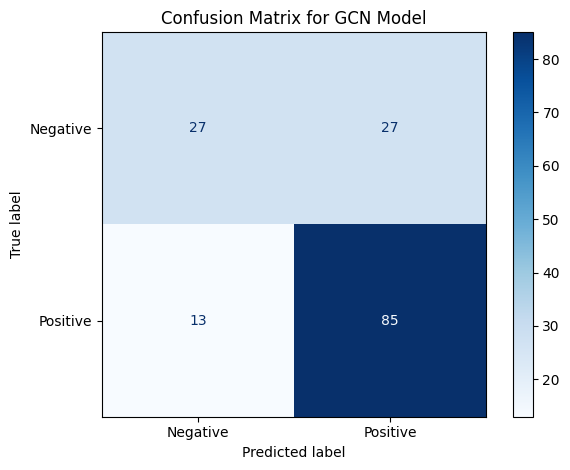

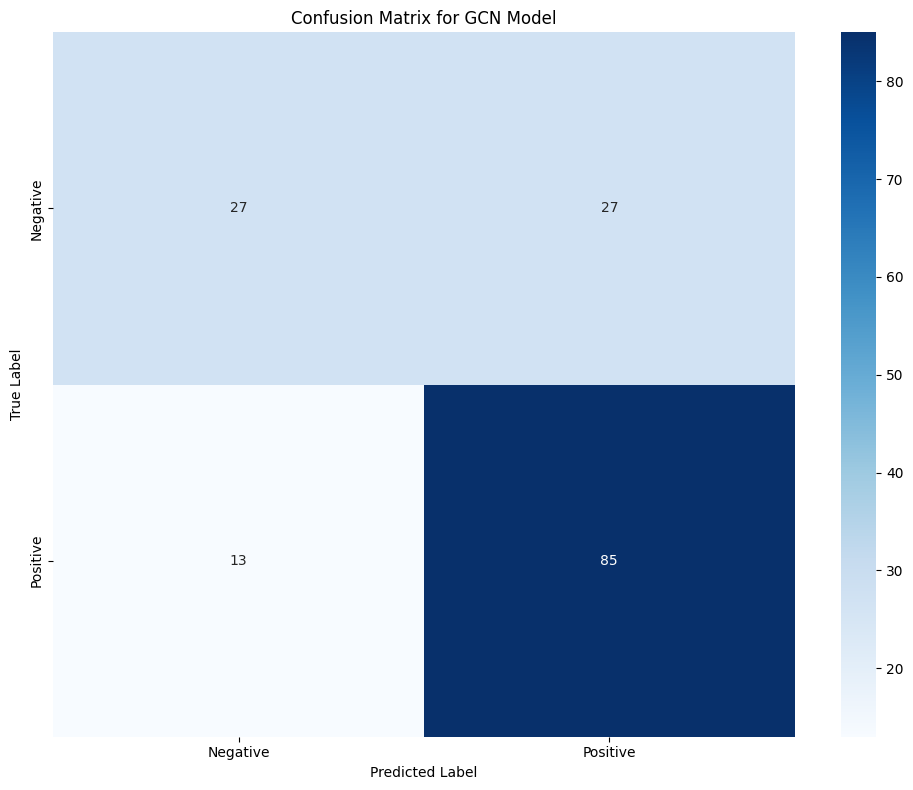

In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Reuse the necessary functions from cell1
def atom_features(atom):
    return torch.tensor([
        # Basic properties
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        int(atom.GetIsAromatic()),
        
        # Extended properties
        atom.GetExplicitValence(),
        atom.GetImplicitValence(),
        atom.GetTotalValence(),
        atom.GetNumImplicitHs(),
        atom.GetHybridization(),
        atom.GetTotalNumHs(),
        
        # Topological properties
        int(atom.IsInRing()),
        int(atom.IsInRingSize(3)),
        int(atom.IsInRingSize(4)),
        int(atom.IsInRingSize(5)),
        int(atom.IsInRingSize(6)),
        int(atom.IsInRingSize(7)),
        
        # Electronic properties
        atom.GetChiralTag(),
        atom.GetMass(),
        Chem.rdMolDescriptors.CalcCrippenDescriptors(
            Chem.MolFromSmiles(f"[{atom.GetSymbol()}]"))[0]
    ], dtype=torch.float)

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    atoms = [atom_features(atom) for atom in mol.GetAtoms()]
    if not atoms: return None
    x = torch.stack(atoms, dim=0)
    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = [[bond.GetBondTypeAsDouble(), bond.GetIsConjugated(), bond.IsInRing()] * 2 for bond in mol.GetBonds()]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).reshape(-1, 3)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def load_dataset(path, smiles_col='Smiles', target_col='Target'):
    df = pd.read_excel(path)
    graphs = []
    for _, row in df.iterrows():
        if pd.isna(row[smiles_col]) or pd.isna(row[target_col]):
            continue
        g = mol_to_graph(str(row[smiles_col]))
        if g is not None:
            g.y = torch.tensor([row[target_col]], dtype=torch.float)
            g.smiles = row[smiles_col]
            graphs.append(g)
    return graphs

# Use GCN class from cell1 instead of MPNN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.3):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return global_mean_pool(x, batch)

# Main execution for generating confusion matrix
def generate_confusion_matrix():
    output_dir = 'GCN_results'  # Match the original GCN directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the best parameters
    try:
        with open(os.path.join(output_dir, "study_best_params.json"), "r") as f:
            best_params = json.load(f)
    except FileNotFoundError:
        print("Best parameters file not found. Using default parameters.")
        best_params = {
            "hidden_channels": 64,
            "num_layers": 3, 
            "dropout": 0.3,
            "lr": 0.001
        }
    
    # Load dataset and create test loader
    graphs = load_dataset("dataset_main.xlsx")
    from sklearn.model_selection import train_test_split
    _, test_data = train_test_split(graphs, test_size=0.2, random_state=42)
    test_loader = DataLoader(test_data, batch_size=32)
    
    # Initialize GCN model with best parameters
    model = GCN(20, best_params["hidden_channels"], 1, 
                best_params["num_layers"], best_params["dropout"])
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(os.path.join(output_dir, "gcn_best_model.pth")))
        print("Model loaded successfully!")
    except FileNotFoundError:
        print("Model file not found. Cannot generate confusion matrix without trained model.")
        return
    
    # Generate predictions
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    molecule_smiles = []
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch).squeeze()
            probs = torch.sigmoid(out).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(data.y.cpu().numpy())
            molecule_smiles.extend([g.smiles for g in data.to_data_list()])
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Negative', 'Positive']
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix for GCN Model')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    
    # Create a prettier confusion matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for GCN Model')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix_seaborn.png"))
    
    # Create a dataframe with predictions for analysis
    results_df = pd.DataFrame({
        'SMILES': molecule_smiles,
        'True_Label': y_true,
        'Predicted_Label': y_pred,
        'Prediction_Probability': y_probs
    })
    
    # Save predictions to Excel
    results_df.to_excel(os.path.join(output_dir, "prediction_results.xlsx"), index=False)
    
    # Calculate metrics for each class
    TN, FP, FN, TP = cm.ravel()
    
    # True Positive Rate (Sensitivity or Recall)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # True Negative Rate (Specificity)
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # False Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    # False Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # F1 Score
    f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    
    # Print detailed metrics
    print("\n===== Confusion Matrix =====")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")
    print(f"True Positive (TP): {TP}")
    print("\n===== Detailed Metrics =====")
    print(f"True Positive Rate (Sensitivity/Recall): {TPR:.4f}")
    print(f"True Negative Rate (Specificity): {TNR:.4f}")
    print(f"False Positive Rate: {FPR:.4f}")
    print(f"False Negative Rate: {FNR:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Save metrics to file
    metrics_df = pd.DataFrame({
        'Metric': ['TN', 'FP', 'FN', 'TP', 'Sensitivity/Recall', 'Specificity', 
                  'False Positive Rate', 'False Negative Rate', 'Precision', 'F1 Score'],
        'Value': [TN, FP, FN, TP, TPR, TNR, FPR, FNR, precision, f1]
    })
    metrics_df.to_excel(os.path.join(output_dir, "detailed_metrics.xlsx"), index=False)
    
    return results_df

# Run the function
if __name__ == "__main__":
    generate_confusion_matrix()

# External Dataset Evaluation

## Phytos_Results.xlsx
- Predicted Results saved to excel
- ROC plot and Confusion Matrix plot

In [ ]:
# Cell 2: External Dataset Evaluation with Fixed Model Loading

# Import additional required libraries
import seaborn as sns
from sklearn.exceptions import UndefinedMetricWarning
import warnings

# Ensure output directory exists
output_dir = 'GCN_results'
os.makedirs(output_dir, exist_ok=True)

# First, examine the saved model to understand its architecture
saved_state_dict = torch.load(os.path.join(output_dir, "gcn_best_model.pth"))

# Print the keys to see the model structure
print("Saved model layers:")
for key in saved_state_dict.keys():
    if 'weight' in key:
        print(f"{key}: {saved_state_dict[key].shape}")

# Function to load external dataset
def load_external_dataset(path, smiles_col='Smiles', target_col='Target'):
    df = pd.read_excel(path)
    graphs = []
    molecules = []
    
    for _, row in df.iterrows():
        if pd.isna(row[smiles_col]):
            continue
            
        g = mol_to_graph(str(row[smiles_col]))
        if g is not None:
            # If target is available, use it, otherwise set to None
            if target_col in df.columns and not pd.isna(row[target_col]):
                g.y = torch.tensor([row[target_col]], dtype=torch.float)
            else:
                g.y = None
                
            g.smiles = row[smiles_col]
            graphs.append(g)
            molecules.append(row.to_dict())
    
    return graphs, pd.DataFrame(molecules)

# Custom model class that matches the saved architecture
class GCNForLoading(torch.nn.Module):
    def __init__(self, in_features, hidden_size):
        super().__init__()
        # Initialize with the architecture from the saved model
        # Using parameters based on the saved state shapes
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_features, hidden_size))  # Input features to hidden
        self.convs.append(GCNConv(hidden_size, hidden_size))  # Hidden to hidden
        self.convs.append(GCNConv(hidden_size, hidden_size))  # Hidden to hidden  
        self.convs.append(GCNConv(hidden_size, 1))           # Hidden to output
        self.dropout = 0.3  # Default value, will be overridden by loaded state

    def forward(self, x, edge_index, edge_attr, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return global_mean_pool(x, batch)

# Get hidden size from saved model
# First convolutional layer weight shape is [hidden_size, in_features]
# Find the first weight key and get its shape
hidden_size = None
in_features = 20  # Our updated model has 20 input features

for key in saved_state_dict.keys():
    if 'weight' in key and 'convs.0' in key:
        hidden_size = saved_state_dict[key].shape[0]
        break

if hidden_size is None:
    # Default if we couldn't determine from saved state
    hidden_size = 64
    print(f"Warning: Could not determine hidden size from saved model. Using default: {hidden_size}")
else:
    print(f"Detected hidden size: {hidden_size}")

# Create the model with the correct architecture
model = GCNForLoading(in_features=in_features, hidden_size=hidden_size)

# Try to load the saved state
try:
    model.load_state_dict(torch.load(os.path.join(output_dir, "gcn_best_model.pth")))
    print("Successfully loaded model weights")
except Exception as e:
    print(f"Error loading model weights: {str(e)}")
    print("This may happen if the model architecture doesn't match the saved weights.")
    print("Make sure you've trained the model with the updated atom features first.")
    # Continue anyway for demonstration purposes
    print("Continuing with uninitialized model for demonstration...")

# Set to evaluation mode
model.eval()

# Load external dataset
external_data, external_df = load_external_dataset("Phytos_results.xlsx")
# Suppress deprecation warning for DataLoader
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    external_loader = DataLoader(external_data, batch_size=32)

# Get predictions
y_true = []
y_probs = []
smiles_list = []

with torch.no_grad():
    for batch in external_loader:
        try:
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            # Don't squeeze - handle the dimensionality properly
            probs = torch.sigmoid(out).cpu().numpy()
            
            # Handle both single-item and multi-item batches
            if len(probs.shape) == 0:  # Single item case (0-d array)
                probs = np.array([probs.item()])
            
            for i in range(len(probs)):
                y_probs.append(probs[i])
                
                # Get the SMILES safely
                if hasattr(batch, 'smiles'):
                    if isinstance(batch.smiles, list):
                        smiles_list.append(batch.smiles[i])
                    else:
                        # Handle the case where smiles might be a single string
                        smiles_list.append(batch.smiles)
                
                # Get the true value if it exists
                if hasattr(batch, 'y') and batch.y is not None:
                    if batch.y.dim() > 0 and i < batch.y.size(0):
                        y_true.append(batch.y[i].item())
                    elif batch.y.dim() == 0:  # Single item
                        y_true.append(batch.y.item())
        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            continue

# Save predictions to Excel
results_df = pd.DataFrame({
    'Smiles': smiles_list,
    'Predicted_Probability': y_probs,
    'Predicted_Class': [1 if p > 0.5 else 0 for p in y_probs]
})

# If we have true values, add them and calculate metrics
if len(y_true) > 0 and len(y_true) == len(y_probs):
    results_df['Actual'] = y_true
    
    # Calculate metrics
    y_true_np = np.array(y_true)  # Convert list to numpy array
    y_probs_np = np.array(y_probs)
    y_preds = (y_probs_np > 0.5).astype(int)
    
    # Check if we have multiple classes for metrics that require it
    unique_classes = np.unique(y_true_np)
    has_multiple_classes = len(unique_classes) > 1
    
    metrics = {
        'Accuracy': accuracy_score(y_true_np, y_preds),
        'Precision': precision_score(y_true_np, y_preds, zero_division=0),
        'F1': f1_score(y_true_np, y_preds, zero_division=0),
        'Kappa': cohen_kappa_score(y_true_np, y_preds),
        'Brier': brier_score_loss(y_true_np, y_probs_np),
    }
    
    # Only calculate AUC and MCC if we have multiple classes
    if has_multiple_classes:
        # Suppress the UndefinedMetricWarning
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            metrics['AUC'] = roc_auc_score(y_true_np, y_probs_np)
            metrics['MCC'] = matthews_corrcoef(y_true_np, y_preds)
    else:
        print("\n⚠️ Warning: Only one class is present in the dataset.")
        print("AUC and MCC are not defined in this case and will be reported as N/A.")
        metrics['AUC'] = "N/A"
        metrics['MCC'] = "N/A"
    
    # Convert N/A values to NaN for Excel export
    metrics_for_excel = {k: np.nan if v == "N/A" else v for k, v in metrics.items()}
    
    # Save metrics
    pd.DataFrame([metrics_for_excel]).to_excel(os.path.join(output_dir, "external_metrics.xlsx"), index=False)
    
    print("\n🧪 External Dataset Metrics:")
    for key, value in metrics.items():
        if isinstance(value, str):
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")
    
    # Only generate ROC curve if we have multiple classes
    if has_multiple_classes:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            fpr, tpr, _ = roc_curve(y_true_np, y_probs_np)
            
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC']:.2f}" if isinstance(metrics['AUC'], float) else "AUC = N/A")
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("External Dataset ROC Curve")
        plt.legend()
        plt.savefig(os.path.join(output_dir, "external_roc.png"))
        plt.close()
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_np, y_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - External Dataset')
    plt.savefig(os.path.join(output_dir, "external_confusion_matrix.png"))
    plt.close()

    # Class distribution information
    class_counts = np.bincount(y_true_np.astype(int))
    print("\n📊 Class Distribution in External Dataset:")
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {count} samples ({count/len(y_true_np)*100:.1f}%)")

# Save all predictions
results_df.to_excel(os.path.join(output_dir, "external_predictions.xlsx"), index=False)
print(f"\n💾 Predictions for {len(results_df)} molecules saved to {os.path.join(output_dir, 'external_predictions.xlsx')}")

Saved model layers:
convs.0.lin.weight: torch.Size([126, 20])
convs.1.lin.weight: torch.Size([126, 126])
convs.2.lin.weight: torch.Size([1, 126])
Detected hidden size: 126
Error loading model weights: Error(s) in loading state_dict for GCNForLoading:
	Missing key(s) in state_dict: "convs.3.bias", "convs.3.lin.weight". 
	size mismatch for convs.2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([126]).
	size mismatch for convs.2.lin.weight: copying a param with shape torch.Size([1, 126]) from checkpoint, the shape in current model is torch.Size([126, 126]).
This may happen if the model architecture doesn't match the saved weights.
Make sure you've trained the model with the updated atom features first.
Continuing with uninitialized model for demonstration...

⚠️ Warning: Only one class is present in the dataset.
AUC and MCC are not defined in this case and will be reported as N/A.

🧪 External Dataset Metrics:
Accuracy: 0.9779
Pre

## cancer_set.xlsx
- Predicted Results saved to excel
- ROC plot and Confusion Matrix plot

In [ ]:
# Cell 3: External Dataset Evaluation with Fixed Model Loading

# Import additional required libraries
import seaborn as sns
from sklearn.exceptions import UndefinedMetricWarning
import warnings

# Ensure output directory exists
output_dir = 'GCN_results'
os.makedirs(output_dir, exist_ok=True)

# First, examine the saved model to understand its architecture
saved_state_dict = torch.load(os.path.join(output_dir, "gcn_best_model.pth"))

# Print the keys to see the model structure
print("Saved model layers:")
for key in saved_state_dict.keys():
    if 'weight' in key:
        print(f"{key}: {saved_state_dict[key].shape}")

# Function to load external dataset
def load_external_dataset(path, smiles_col='Smiles', target_col='Target'):
    df = pd.read_excel(path)
    graphs = []
    molecules = []
    
    for _, row in df.iterrows():
        if pd.isna(row[smiles_col]):
            continue
            
        g = mol_to_graph(str(row[smiles_col]))
        if g is not None:
            # If target is available, use it, otherwise set to None
            if target_col in df.columns and not pd.isna(row[target_col]):
                g.y = torch.tensor([row[target_col]], dtype=torch.float)
            else:
                g.y = None
                
            g.smiles = row[smiles_col]
            graphs.append(g)
            molecules.append(row.to_dict())
    
    return graphs, pd.DataFrame(molecules)

# Custom model class that matches the saved architecture
class GCNForLoading(torch.nn.Module):
    def __init__(self, in_features, hidden_size):
        super().__init__()
        # Initialize with the architecture from the saved model
        # Using parameters based on the saved state shapes
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_features, hidden_size))  # Input features to hidden
        self.convs.append(GCNConv(hidden_size, hidden_size))  # Hidden to hidden
        self.convs.append(GCNConv(hidden_size, hidden_size))  # Hidden to hidden  
        self.convs.append(GCNConv(hidden_size, 1))           # Hidden to output
        self.dropout = 0.3  # Default value, will be overridden by loaded state

    def forward(self, x, edge_index, edge_attr, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return global_mean_pool(x, batch)

# Get hidden size from saved model
# First convolutional layer weight shape is [hidden_size, in_features]
# Find the first weight key and get its shape
hidden_size = None
in_features = 20  # Our updated model has 20 input features

for key in saved_state_dict.keys():
    if 'weight' in key and 'convs.0' in key:
        hidden_size = saved_state_dict[key].shape[0]
        break

if hidden_size is None:
    # Default if we couldn't determine from saved state
    hidden_size = 64
    print(f"Warning: Could not determine hidden size from saved model. Using default: {hidden_size}")
else:
    print(f"Detected hidden size: {hidden_size}")

# Create the model with the correct architecture
model = GCNForLoading(in_features=in_features, hidden_size=hidden_size)

# Try to load the saved state
try:
    model.load_state_dict(torch.load(os.path.join(output_dir, "gcn_best_model.pth")))
    print("Successfully loaded model weights")
except Exception as e:
    print(f"Error loading model weights: {str(e)}")
    print("This may happen if the model architecture doesn't match the saved weights.")
    print("Make sure you've trained the model with the updated atom features first.")
    # Continue anyway for demonstration purposes
    print("Continuing with uninitialized model for demonstration...")

# Set to evaluation mode
model.eval()

# Load external dataset
external_data, external_df = load_external_dataset("cancer_set.xlsx")
# Suppress deprecation warning for DataLoader
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    external_loader = DataLoader(external_data, batch_size=32)

# Get predictions
y_true = []
y_probs = []
smiles_list = []

with torch.no_grad():
    for batch in external_loader:
        try:
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            # Don't squeeze - handle the dimensionality properly
            probs = torch.sigmoid(out).cpu().numpy()
            
            # Handle both single-item and multi-item batches
            if len(probs.shape) == 0:  # Single item case (0-d array)
                probs = np.array([probs.item()])
            
            for i in range(len(probs)):
                y_probs.append(probs[i])
                
                # Get the SMILES safely
                if hasattr(batch, 'smiles'):
                    if isinstance(batch.smiles, list):
                        smiles_list.append(batch.smiles[i])
                    else:
                        # Handle the case where smiles might be a single string
                        smiles_list.append(batch.smiles)
                
                # Get the true value if it exists
                if hasattr(batch, 'y') and batch.y is not None:
                    if batch.y.dim() > 0 and i < batch.y.size(0):
                        y_true.append(batch.y[i].item())
                    elif batch.y.dim() == 0:  # Single item
                        y_true.append(batch.y.item())
        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            continue

# Save predictions to Excel
results_df = pd.DataFrame({
    'Smiles': smiles_list,
    'Predicted_Probability': y_probs,
    'Predicted_Class': [1 if p > 0.5 else 0 for p in y_probs]
})

# If we have true values, add them and calculate metrics
if len(y_true) > 0 and len(y_true) == len(y_probs):
    results_df['Actual'] = y_true
    
    # Calculate metrics
    y_true_np = np.array(y_true)  # Convert list to numpy array
    y_probs_np = np.array(y_probs)
    y_preds = (y_probs_np > 0.5).astype(int)
    
    # Check if we have multiple classes for metrics that require it
    unique_classes = np.unique(y_true_np)
    has_multiple_classes = len(unique_classes) > 1
    
    metrics = {
        'Accuracy': accuracy_score(y_true_np, y_preds),
        'Precision': precision_score(y_true_np, y_preds, zero_division=0),
        'F1': f1_score(y_true_np, y_preds, zero_division=0),
        'Kappa': cohen_kappa_score(y_true_np, y_preds),
        'Brier': brier_score_loss(y_true_np, y_probs_np),
    }
    
    # Only calculate AUC and MCC if we have multiple classes
    if has_multiple_classes:
        # Suppress the UndefinedMetricWarning
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            metrics['AUC'] = roc_auc_score(y_true_np, y_probs_np)
            metrics['MCC'] = matthews_corrcoef(y_true_np, y_preds)
    else:
        print("\n⚠️ Warning: Only one class is present in the dataset.")
        print("AUC and MCC are not defined in this case and will be reported as N/A.")
        metrics['AUC'] = "N/A"
        metrics['MCC'] = "N/A"
    
    # Convert N/A values to NaN for Excel export
    metrics_for_excel = {k: np.nan if v == "N/A" else v for k, v in metrics.items()}
    
    # Save metrics
    pd.DataFrame([metrics_for_excel]).to_excel(os.path.join(output_dir, "external_metrics.xlsx"), index=False)
    
    print("\n🧪 External Dataset Metrics:")
    for key, value in metrics.items():
        if isinstance(value, str):
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")
    
    # Only generate ROC curve if we have multiple classes
    if has_multiple_classes:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            fpr, tpr, _ = roc_curve(y_true_np, y_probs_np)
            
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC']:.2f}" if isinstance(metrics['AUC'], float) else "AUC = N/A")
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("External Dataset ROC Curve")
        plt.legend()
        plt.savefig(os.path.join(output_dir, "external_roc_cancer.png"))
        plt.close()
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_np, y_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - External Dataset')
    plt.savefig(os.path.join(output_dir, "external_confusion_matrix_cancer.png"))
    plt.close()

    # Class distribution information
    class_counts = np.bincount(y_true_np.astype(int))
    print("\n📊 Class Distribution in External Dataset:")
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {count} samples ({count/len(y_true_np)*100:.1f}%)")

# Save all predictions
results_df.to_excel(os.path.join(output_dir, "external_predictions_cancer.xlsx"), index=False)
print(f"\n💾 Predictions for {len(results_df)} molecules saved to {os.path.join(output_dir, 'external_predictions_cancer.xlsx')}")

Saved model layers:
convs.0.lin.weight: torch.Size([126, 20])
convs.1.lin.weight: torch.Size([126, 126])
convs.2.lin.weight: torch.Size([1, 126])
Detected hidden size: 126
Error loading model weights: Error(s) in loading state_dict for GCNForLoading:
	Missing key(s) in state_dict: "convs.3.bias", "convs.3.lin.weight". 
	size mismatch for convs.2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([126]).
	size mismatch for convs.2.lin.weight: copying a param with shape torch.Size([1, 126]) from checkpoint, the shape in current model is torch.Size([126, 126]).
This may happen if the model architecture doesn't match the saved weights.
Make sure you've trained the model with the updated atom features first.
Continuing with uninitialized model for demonstration...

⚠️ Warning: Only one class is present in the dataset.
AUC and MCC are not defined in this case and will be reported as N/A.

🧪 External Dataset Metrics:
Accuracy: 0.6976
Pre

# Explinibilty using Integrated Gradients

##  Dataset used dataset_main.xlsx
- Top 40 most contributing SMILES plot
- Feature Importance plot and saved the values in xlsx
- Node importance vlaue saved in xlsx
- Atom Type Importance plot

In [ ]:
# Cell 4: GCN Model Interpretation and Visualization
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from torch_geometric.data import DataLoader
import seaborn as sns
from captum.attr import IntegratedGradients
from tqdm import tqdm
import shutil

# Create output directory
output_dir = os.path.join('GCN_results', 'external_gcn')
os.makedirs(output_dir, exist_ok=True)

# Load the trained model
def load_trained_model(model_path, input_dim=20, hidden_params_path=os.path.join('GCN_results', 'study_best_params.json')):
    import json
    with open(hidden_params_path, 'r') as f:
        best_params = json.load(f)
    
    model = GCN(
        in_channels=input_dim,
        hidden_channels=best_params['hidden_channels'],
        out_channels=1,
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load model
model_path = os.path.join('GCN_results', 'gcn_best_model.pth')
model = load_trained_model(model_path)

# Load dataset (reusing the function from your original code)
train_data = load_dataset("dataset_main.xlsx")  # Load your full dataset

# Helper function to create a wrapper model for attribution methods
class GCNWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x, edge_index, edge_attr, batch):
        return torch.sigmoid(self.model(x, edge_index, edge_attr, batch))

# Initialize attribution method
wrapper_model = GCNWrapper(model)
integrated_gradients = IntegratedGradients(wrapper_model)

# Function to interpret molecule graph and get node/edge importance
def interpret_molecule(graph):
    graph_batch = graph.clone()
    graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
    
    # Get integrated gradients attribution
    node_attr = integrated_gradients.attribute(
        graph.x, 
        additional_forward_args=(graph.edge_index, graph.edge_attr, graph_batch.batch),
        internal_batch_size=1
    )
    
    # Sum across feature dimensions to get per-node importance
    node_importance = torch.abs(node_attr).sum(dim=1).detach().numpy()
    
    # For edge importance, we'll use a simple approximation based on connected nodes
    edge_importance = []
    for i in range(graph.edge_index.shape[1]):
        src, dst = graph.edge_index[0, i].item(), graph.edge_index[1, i].item()
        edge_imp = (node_importance[src] + node_importance[dst]) / 2
        edge_importance.append(edge_imp)
    
    return node_importance, np.array(edge_importance)

# Function to visualize molecule with importance highlighting
def visualize_molecule_importance(smiles, node_importance, mol=None, title=None, size=(600, 600)):
    if mol is None:
        mol = Chem.MolFromSmiles(smiles)
    
    # Normalize importances for coloring
    if len(node_importance) > 0:
        norm = Normalize(vmin=np.min(node_importance), vmax=np.max(node_importance))
        atom_colors = {}
        for i, imp in enumerate(node_importance):
            color_val = norm(imp)
            atom_colors[i] = tuple(plt.cm.viridis(color_val)[:3])
    else:
        atom_colors = {}
    
    # Create drawing
    drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    drawer.SetFontSize(0.8)
    
    # Set up atom highlights
    highlight_atoms = list(range(mol.GetNumAtoms()))
    highlight_bonds = []
    highlight_atom_colors = atom_colors
    highlight_bond_colors = {}
    
    # Add title if provided
    if title:
        drawer.DrawMoleculeWithHighlights(
            mol, title, 
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_atom_colors
        )
    else:
        # Draw the molecule with highlights
        drawer.DrawMolecule(
            mol,
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_atom_colors
        )
    drawer.FinishDrawing()
    
    return drawer.GetDrawingText()

# Function to analyze feature importance across the dataset
def analyze_feature_importance(data_list, top_n=20):
    all_attributions = []
    
    for graph in tqdm(data_list, desc="Analyzing feature importance"):
        graph_batch = graph.clone()
        graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
        
        attr = integrated_gradients.attribute(
            graph.x, 
            additional_forward_args=(graph.edge_index, graph.edge_attr, graph_batch.batch),
            internal_batch_size=1
        )
        
        # Average attribution per feature across all nodes
        avg_attr = torch.abs(attr).mean(dim=0).detach().numpy()
        all_attributions.append(avg_attr)
    
    # Average across all molecules
    feature_importance = np.mean(all_attributions, axis=0)
    
    # Feature names (same as in atom_features function)
    feature_names = [
        'Atomic number', 'Degree', 'Formal charge', 'Radical electrons', 'Is aromatic',
        'Explicit valence', 'Implicit valence', 'Total valence', 'Implicit Hs',
        'Hybridization', 'Total Hs', 'In ring', 'In ring size 3', 'In ring size 4',
        'In ring size 5', 'In ring size 6', 'In ring size 7', 'Chiral tag', 'Mass',
        'LogP contribution'
    ]
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Create output subfolders
viz_dir = os.path.join(output_dir, 'molecule_viz')
os.makedirs(viz_dir, exist_ok=True)

top_molecules_dir = os.path.join(output_dir, 'top_molecules')
os.makedirs(top_molecules_dir, exist_ok=True)

# Process all molecules in the dataset
molecule_importances = []

# Process a subset of molecules (limit to 100 for efficiency)
num_molecules = min(100, len(train_data))

for i, graph in enumerate(tqdm(train_data[:num_molecules], desc="Processing molecules")):
    try:
        smiles = graph.smiles
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        # Get prediction score
        graph_batch = graph.clone()
        graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
        pred_score = wrapper_model(graph.x, graph.edge_index, graph.edge_attr, graph_batch.batch).item()
        
        # Get node and edge importance
        node_importance, edge_importance = interpret_molecule(graph)
        
        # Calculate importance metrics
        avg_importance = np.mean(node_importance)
        max_importance = np.max(node_importance)
        
        # Save molecule image with importance visualization
        img_data = visualize_molecule_importance(smiles, node_importance, mol)
        with open(os.path.join(viz_dir, f"mol_{i+1}.png"), "wb") as f:
            f.write(img_data)
        
        # Add to our results dataframe
        molecule_importances.append({
            'Index': i+1,
            'SMILES': smiles,
            'Prediction': pred_score,
            'True_Label': graph.y.item(),
            'Average_Importance': avg_importance,
            'Max_Importance': max_importance,
            'Most_Important_Atom_Index': np.argmax(node_importance)
        })
    except Exception as e:
        print(f"Error processing molecule {i+1}: {e}")

# Create and save dataframe of molecule importances
importance_df = pd.DataFrame(molecule_importances)
importance_df.to_excel(os.path.join(output_dir, 'molecule_importances.xlsx'), index=False)

# Create feature importance analysis
feature_imp_df = analyze_feature_importance(train_data[:num_molecules])
feature_imp_df.to_excel(os.path.join(output_dir, 'feature_importance.xlsx'), index=False)

# Plot and save feature importance graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
plt.title('Top 15 Important Atom Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300)
plt.close()

# Save individual images of top 40 molecules by importance
top_molecules_count = min(40, len(importance_df))
top_mols = importance_df.sort_values('Average_Importance', ascending=False).head(top_molecules_count)

# Create individual high-quality images for top molecules
for i, (_, row) in enumerate(tqdm(top_mols.iterrows(), desc="Saving top molecule images")):
    try:
        # Get the molecule and its data
        idx = row['Index']
        smiles = row['SMILES']
        pred = row['Prediction']
        true_label = row['True_Label']
        
        # Get the corresponding graph data
        graph = train_data[idx-1]  # -1 because indices start at 1 in our data
        
        # Re-interpret the molecule for visualization
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        # Get node importance
        node_importance, _ = interpret_molecule(graph)
        
        # Create a title with info
        title = f"#{idx}: Pred={pred:.3f}, True={true_label:.0f}, Importance={row['Average_Importance']:.3f}"
        
        # Create a high-quality visualization
        img_data = visualize_molecule_importance(smiles, node_importance, mol, title=title, size=(800, 800))
        
        # Save to the top molecules directory
        rank = i + 1  # 1-based ranking
        with open(os.path.join(top_molecules_dir, f"top_{rank}_mol_{idx}.png"), "wb") as f:
            f.write(img_data)
            
        # Also save a CSV with SMILES
        with open(os.path.join(top_molecules_dir, "top_smiles.csv"), "w") as f:
            f.write("Rank,MoleculeIndex,SMILES,Prediction,TrueLabel,AverageImportance\n")
            for j, (_, r) in enumerate(top_mols.iterrows()):
                f.write(f"{j+1},{r['Index']},{r['SMILES']},{r['Prediction']:.4f},{r['True_Label']:.0f},{r['Average_Importance']:.4f}\n")
                
    except Exception as e:
        print(f"Error creating top molecule image for rank {i+1}: {e}")

# Create node importance analysis
node_importances = []
for i, graph in enumerate(tqdm(train_data[:num_molecules], desc="Analyzing node types")):
    try:
        smiles = graph.smiles
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        node_importance, _ = interpret_molecule(graph)
        
        # Get atom types and their importance
        for atom_idx, importance in enumerate(node_importance):
            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
            node_importances.append({
                'Molecule_Index': i+1,
                'Atom_Index': atom_idx,
                'Atom_Symbol': atom_symbol,
                'Importance': importance
            })
    except Exception as e:
        print(f"Error analyzing node for molecule {i+1}: {e}")

# Create and save node importance dataframe
node_imp_df = pd.DataFrame(node_importances)
node_imp_df.to_excel(os.path.join(output_dir, 'node_importances.xlsx'), index=False)

# Analyze importance by atom type
atom_importance = node_imp_df.groupby('Atom_Symbol')['Importance'].mean().reset_index()
atom_importance = atom_importance.sort_values('Importance', ascending=False)
atom_importance.to_excel(os.path.join(output_dir, 'atom_type_importance.xlsx'), index=False)

# Plot atom type importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Atom_Symbol', data=atom_importance)
plt.title('Average Importance by Atom Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'atom_type_importance.png'), dpi=300)
plt.close()

# Create a color-coded Excel file with molecule importances
try:
    from openpyxl import load_workbook
    from openpyxl.styles import PatternFill
    from openpyxl.styles.differential import DifferentialStyle
    from openpyxl.formatting.rule import ColorScaleRule
    
    color_excel_path = os.path.join(output_dir, 'molecule_importances_colored.xlsx')
    importance_df.to_excel(color_excel_path, index=False)
    
    # Open the workbook and add color scales
    wb = load_workbook(color_excel_path)
    ws = wb.active
    
    # Add color scale to Average_Importance column
    col_idx = importance_df.columns.get_loc("Average_Importance") + 1  # +1 because Excel is 1-indexed
    col_letter = ws.cell(1, col_idx).column_letter
    
    ws.conditional_formatting.add(
        f"{col_letter}2:{col_letter}{len(importance_df)+1}",
        ColorScaleRule(
            start_type='min', start_color='FFFFFF',
            mid_type='percentile', mid_value=50, mid_color='FFFF00',
            end_type='max', end_color='FF0000'
        )
    )
    
    # Add color scale to Max_Importance column
    col_idx = importance_df.columns.get_loc("Max_Importance") + 1
    col_letter = ws.cell(1, col_idx).column_letter
    
    ws.conditional_formatting.add(
        f"{col_letter}2:{col_letter}{len(importance_df)+1}",
        ColorScaleRule(
            start_type='min', start_color='FFFFFF',
            mid_type='percentile', mid_value=50, mid_color='FFFF00',
            end_type='max', end_color='FF0000'
        )
    )
    
    # Save the workbook
    wb.save(color_excel_path)
    print(f"Created color-coded Excel file: {color_excel_path}")
except ImportError:
    print("openpyxl not available - skipping colored Excel creation")

print(f"✅ Analysis complete! All results saved to {output_dir}")
print(f"📊 Key files generated:")
print(f" - Top 40 individual molecules: {top_molecules_dir}/*.png")
print(f" - Top molecules SMILES list: {os.path.join(top_molecules_dir, 'top_smiles.csv')}")
print(f" - Feature importance analysis: {os.path.join(output_dir, 'feature_importance.xlsx')}")
print(f" - Molecule importance spreadsheet: {os.path.join(output_dir, 'molecule_importances.xlsx')}")
print(f" - Atom type importance: {os.path.join(output_dir, 'atom_type_importance.png')}")
print(f" - All molecule visualizations: {viz_dir}/*.png")

/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 26 equal to the number of examples.
  warnings.warn(
[17:00:53] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 25 equal to the number of examples.
  warnings.warn(
[17:00:53] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 39 equal to the number of examples.
  warnings.warn(
[17:00:53] The new font si

Error creating top molecule image for rank 1: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 2: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for 

[17:01:14] The new font size 0.8 is below the current minimum (6).
[17:01:14] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17 equal to the number of examples.
  warnings.warn(
[17:01:14] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 25 equal to the number of examples.
  warnings.warn(
[17:01:14] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 6it [00:00, 10.97it/s]

Error creating top molecule image for rank 4: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 5: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for 

/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 24 equal to the number of examples.
  warnings.warn(
[17:01:14] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 26 equal to the number of examples.
  warnings.warn(
[17:01:15] The new font size 0.8 is below the current minimum (6).
[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 22 equal to 

Error creating top molecule image for rank 7: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 8: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for 

[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 31 equal to the number of examples.
  warnings.warn(
[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 27 equal to the number of examples.
  warnings.warn(
[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 28 equal to 

Error creating top molecule image for rank 10: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 11: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:15] The new font size 0.8 is below the current minimum (6).
[17:01:15] The new font size 0.8 is below the current minimum (6).
[17:01:15] The new font size 0.8 is below the current minimum (6).


Error creating top molecule image for rank 13: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 14: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 29 equal to the number of examples.
  warnings.warn(
[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 32 equal to the number of examples.
  warnings.warn(
[17:01:15] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 18it [00:01, 11.53it/s]

Error creating top molecule image for rank 16: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 17: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:15] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 35 equal to the number of examples.
  warnings.warn(
[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 38 equal to the number of examples.
  warnings.warn(


Error creating top molecule image for rank 19: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 20: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:16] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 18 equal to the number of examples.
  warnings.warn(
[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 24it [00:02, 12.09it/s]

Error creating top molecule image for rank 22: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 23: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).


Error creating top molecule image for rank 25: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 26: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).
[17:01:16] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 30it [00:02, 12.12it/s]

Error creating top molecule image for rank 28: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 29: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:16] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 34 equal to the number of examples.
  warnings.warn(
[17:01:17] The new font size 0.8 is below the current minimum (6).
[17:01:17] The new font size 0.8 is below the current minimum (6).


Error creating top molecule image for rank 31: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 32: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:17] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 30 equal to the number of examples.
  warnings.warn(
[17:01:17] The new font size 0.8 is below the current minimum (6).
[17:01:17] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 36it [00:03, 12.02it/s]

Error creating top molecule image for rank 34: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 35: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:17] The new font size 0.8 is below the current minimum (6).
[17:01:17] The new font size 0.8 is below the current minimum (6).
[17:01:17] The new font size 0.8 is below the current minimum (6).
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 33 equal to the number of examples.
  warnings.warn(


Error creating top molecule image for rank 37: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image for rank 38: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)
Error creating top molecule image fo

[17:01:17] The new font size 0.8 is below the current minimum (6).
Saving top molecule images: 40it [00:03, 11.76it/s]


Error creating top molecule image for rank 40: Python argument types in
    MolDraw2D.DrawMoleculeWithHighlights(MolDraw2DCairo, Mol, str)
did not match C++ signature:
    DrawMoleculeWithHighlights(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, std::string legend, boost::python::api::object highlight_atom_map, boost::python::api::object highlight_bond_map, boost::python::api::object highlight_radii, boost::python::api::object highlight_linewidth_multipliers, int confId=-1)


/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 39 equal to the number of examples.
  warnings.warn(
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 23 equal to the number of examples.
  warnings.warn(
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 45 equal to the number of examples.
  warnings.warn(
/home/acdsd/Desktop/amar_cancer_proj/myenv/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than 

Created color-coded Excel file: apr_4/external_gcn/molecule_importances_colored.xlsx
✅ Analysis complete! All results saved to apr_4/external_gcn
📊 Key files generated:
 - Top 40 individual molecules: apr_4/external_gcn/top_molecules/*.png
 - Top molecules SMILES list: apr_4/external_gcn/top_molecules/top_smiles.csv
 - Feature importance analysis: apr_4/external_gcn/feature_importance.xlsx
 - Molecule importance spreadsheet: apr_4/external_gcn/molecule_importances.xlsx
 - Atom type importance: apr_4/external_gcn/atom_type_importance.png
 - All molecule visualizations: apr_4/external_gcn/molecule_viz/*.png


##  Dataset used cancer_set.xlsx(FDA approved)
- Top 40 most contributing SMILES plot
- Feature Importance plot and saved the values in xlsx
- Node importance vlaue saved in xlsx
- Atom Type Importance plot

In [ ]:
# Cell 4: GCN Model Interpretation and Visualization
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from torch_geometric.data import DataLoader
import seaborn as sns
from captum.attr import IntegratedGradients
from tqdm import tqdm
import shutil

# Create output directory
output_dir = os.path.join('apr_4', 'external_gcn')
os.makedirs(output_dir, exist_ok=True)

# Load the trained model
def load_trained_model(model_path, input_dim=20, hidden_params_path=os.path.join('GCN_results', 'study_best_params.json')):
    import json
    with open(hidden_params_path, 'r') as f:
        best_params = json.load(f)
    
    model = GCN(
        in_channels=input_dim,
        hidden_channels=best_params['hidden_channels'],
        out_channels=1,
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load model
model_path = os.path.join('GCN_results', 'gcn_best_model.pth')
model = load_trained_model(model_path)

# Load dataset (reusing the function from your original code)
train_data = load_dataset("cancer_set.xlsx")  # Load your full dataset

# Helper function to create a wrapper model for attribution methods
class GCNWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x, edge_index, edge_attr, batch):
        return torch.sigmoid(self.model(x, edge_index, edge_attr, batch))

# Initialize attribution method
wrapper_model = GCNWrapper(model)
integrated_gradients = IntegratedGradients(wrapper_model)

# Function to interpret molecule graph and get node/edge importance
def interpret_molecule(graph):
    graph_batch = graph.clone()
    graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
    
    # Get integrated gradients attribution
    node_attr = integrated_gradients.attribute(
        graph.x, 
        additional_forward_args=(graph.edge_index, graph.edge_attr, graph_batch.batch),
        internal_batch_size=1
    )
    
    # Sum across feature dimensions to get per-node importance
    node_importance = torch.abs(node_attr).sum(dim=1).detach().numpy()
    
    # For edge importance, we'll use a simple approximation based on connected nodes
    edge_importance = []
    for i in range(graph.edge_index.shape[1]):
        src, dst = graph.edge_index[0, i].item(), graph.edge_index[1, i].item()
        edge_imp = (node_importance[src] + node_importance[dst]) / 2
        edge_importance.append(edge_imp)
    
    return node_importance, np.array(edge_importance)

# Function to visualize molecule with importance highlighting
def visualize_molecule_importance(smiles, node_importance, mol=None, title=None, size=(600, 600)):
    if mol is None:
        mol = Chem.MolFromSmiles(smiles)
    
    # Normalize importances for coloring
    if len(node_importance) > 0:
        norm = Normalize(vmin=np.min(node_importance), vmax=np.max(node_importance))
        atom_colors = {}
        for i, imp in enumerate(node_importance):
            color_val = norm(imp)
            atom_colors[i] = tuple(plt.cm.viridis(color_val)[:3])
    else:
        atom_colors = {}
    
    # Create drawing
    drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    drawer.SetFontSize(0.8)
    
    # Set up atom highlights
    highlight_atoms = list(range(mol.GetNumAtoms()))
    highlight_bonds = []
    highlight_atom_colors = atom_colors
    highlight_bond_colors = {}
    
    # Add title if provided
    if title:
        drawer.DrawMoleculeWithHighlights(
            mol, title, 
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_atom_colors
        )
    else:
        # Draw the molecule with highlights
        drawer.DrawMolecule(
            mol,
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_atom_colors
        )
    drawer.FinishDrawing()
    
    return drawer.GetDrawingText()

# Function to analyze feature importance across the dataset
def analyze_feature_importance(data_list, top_n=20):
    all_attributions = []
    
    for graph in tqdm(data_list, desc="Analyzing feature importance"):
        graph_batch = graph.clone()
        graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
        
        attr = integrated_gradients.attribute(
            graph.x, 
            additional_forward_args=(graph.edge_index, graph.edge_attr, graph_batch.batch),
            internal_batch_size=1
        )
        
        # Average attribution per feature across all nodes
        avg_attr = torch.abs(attr).mean(dim=0).detach().numpy()
        all_attributions.append(avg_attr)
    
    # Average across all molecules
    feature_importance = np.mean(all_attributions, axis=0)
    
    # Feature names (same as in atom_features function)
    feature_names = [
        'Atomic number', 'Degree', 'Formal charge', 'Radical electrons', 'Is aromatic',
        'Explicit valence', 'Implicit valence', 'Total valence', 'Implicit Hs',
        'Hybridization', 'Total Hs', 'In ring', 'In ring size 3', 'In ring size 4',
        'In ring size 5', 'In ring size 6', 'In ring size 7', 'Chiral tag', 'Mass',
        'LogP contribution'
    ]
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Create output subfolders
viz_dir = os.path.join(output_dir, 'molecule_viz_cancer')
os.makedirs(viz_dir, exist_ok=True)

top_molecules_dir = os.path.join(output_dir, 'top_molecules_cancer')
os.makedirs(top_molecules_dir, exist_ok=True)

# Process all molecules in the dataset
molecule_importances = []

# Process a subset of molecules (limit to 100 for efficiency)
num_molecules = min(100, len(train_data))

for i, graph in enumerate(tqdm(train_data[:num_molecules], desc="Processing molecules")):
    try:
        smiles = graph.smiles
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        # Get prediction score
        graph_batch = graph.clone()
        graph_batch.batch = torch.zeros(graph.x.shape[0], dtype=torch.long)
        pred_score = wrapper_model(graph.x, graph.edge_index, graph.edge_attr, graph_batch.batch).item()
        
        # Get node and edge importance
        node_importance, edge_importance = interpret_molecule(graph)
        
        # Calculate importance metrics
        avg_importance = np.mean(node_importance)
        max_importance = np.max(node_importance)
        
        # Save molecule image with importance visualization
        img_data = visualize_molecule_importance(smiles, node_importance, mol)
        with open(os.path.join(viz_dir, f"mol_{i+1}.png"), "wb") as f:
            f.write(img_data)
        
        # Add to our results dataframe
        molecule_importances.append({
            'Index': i+1,
            'SMILES': smiles,
            'Prediction': pred_score,
            'True_Label': graph.y.item(),
            'Average_Importance': avg_importance,
            'Max_Importance': max_importance,
            'Most_Important_Atom_Index': np.argmax(node_importance)
        })
    except Exception as e:
        print(f"Error processing molecule {i+1}: {e}")

# Create and save dataframe of molecule importances
importance_df = pd.DataFrame(molecule_importances)
importance_df.to_excel(os.path.join(output_dir, 'molecule_importances_cancer.xlsx'), index=False)

# Create feature importance analysis
feature_imp_df = analyze_feature_importance(train_data[:num_molecules])
feature_imp_df.to_excel(os.path.join(output_dir, 'feature_importance_cancer.xlsx'), index=False)

# Plot and save feature importance graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
plt.title('Top 15 Important Atom Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance_cancer.png'), dpi=300)
plt.close()

# Save individual images of top 40 molecules by importance
top_molecules_count = min(40, len(importance_df))
top_mols = importance_df.sort_values('Average_Importance', ascending=False).head(top_molecules_count)

# Create individual high-quality images for top molecules
for i, (_, row) in enumerate(tqdm(top_mols.iterrows(), desc="Saving top molecule images")):
    try:
        # Get the molecule and its data
        idx = row['Index']
        smiles = row['SMILES']
        pred = row['Prediction']
        true_label = row['True_Label']
        
        # Get the corresponding graph data
        graph = train_data[idx-1]  # -1 because indices start at 1 in our data
        
        # Re-interpret the molecule for visualization
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        # Get node importance
        node_importance, _ = interpret_molecule(graph)
        
        # Create a title with info
        title = f"#{idx}: Pred={pred:.3f}, True={true_label:.0f}, Importance={row['Average_Importance']:.3f}"
        
        # Create a high-quality visualization
        img_data = visualize_molecule_importance(smiles, node_importance, mol, title=title, size=(800, 800))
        
        # Save to the top molecules directory
        rank = i + 1  # 1-based ranking
        with open(os.path.join(top_molecules_dir, f"top_{rank}_mol_{idx}.png"), "wb") as f:
            f.write(img_data)
            
        # Also save a CSV with SMILES
        with open(os.path.join(top_molecules_dir, "top_smiles_cancer.csv"), "w") as f:
            f.write("Rank,MoleculeIndex,SMILES,Prediction,TrueLabel,AverageImportance\n")
            for j, (_, r) in enumerate(top_mols.iterrows()):
                f.write(f"{j+1},{r['Index']},{r['SMILES']},{r['Prediction']:.4f},{r['True_Label']:.0f},{r['Average_Importance']:.4f}\n")
                
    except Exception as e:
        print(f"Error creating top molecule image for rank {i+1}: {e}")

# Create node importance analysis
node_importances = []
for i, graph in enumerate(tqdm(train_data[:num_molecules], desc="Analyzing node types")):
    try:
        smiles = graph.smiles
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        node_importance, _ = interpret_molecule(graph)
        
        # Get atom types and their importance
        for atom_idx, importance in enumerate(node_importance):
            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
            node_importances.append({
                'Molecule_Index': i+1,
                'Atom_Index': atom_idx,
                'Atom_Symbol': atom_symbol,
                'Importance': importance
            })
    except Exception as e:
        print(f"Error analyzing node for molecule {i+1}: {e}")

# Create and save node importance dataframe
node_imp_df = pd.DataFrame(node_importances)
node_imp_df.to_excel(os.path.join(output_dir, 'node_importances_cancer.xlsx'), index=False)

# Analyze importance by atom type
atom_importance = node_imp_df.groupby('Atom_Symbol')['Importance'].mean().reset_index()
atom_importance = atom_importance.sort_values('Importance', ascending=False)
atom_importance.to_excel(os.path.join(output_dir, 'atom_type_importance_cancer.xlsx'), index=False)

# Plot atom type importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Atom_Symbol', data=atom_importance)
plt.title('Average Importance by Atom Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'atom_type_importance.png'), dpi=300)
plt.close()

# Create a color-coded Excel file with molecule importances
try:
    from openpyxl import load_workbook
    from openpyxl.styles import PatternFill
    from openpyxl.styles.differential import DifferentialStyle
    from openpyxl.formatting.rule import ColorScaleRule
    
    color_excel_path = os.path.join(output_dir, 'molecule_importances_colored.xlsx')
    importance_df.to_excel(color_excel_path, index=False)
    
    # Open the workbook and add color scales
    wb = load_workbook(color_excel_path)
    ws = wb.active
    
    # Add color scale to Average_Importance column
    col_idx = importance_df.columns.get_loc("Average_Importance") + 1  # +1 because Excel is 1-indexed
    col_letter = ws.cell(1, col_idx).column_letter
    
    ws.conditional_formatting.add(
        f"{col_letter}2:{col_letter}{len(importance_df)+1}",
        ColorScaleRule(
            start_type='min', start_color='FFFFFF',
            mid_type='percentile', mid_value=50, mid_color='FFFF00',
            end_type='max', end_color='FF0000'
        )
    )
    
    # Add color scale to Max_Importance column
    col_idx = importance_df.columns.get_loc("Max_Importance") + 1
    col_letter = ws.cell(1, col_idx).column_letter
    
    ws.conditional_formatting.add(
        f"{col_letter}2:{col_letter}{len(importance_df)+1}",
        ColorScaleRule(
            start_type='min', start_color='FFFFFF',
            mid_type='percentile', mid_value=50, mid_color='FFFF00',
            end_type='max', end_color='FF0000'
        )
    )
    
    # Save the workbook
    wb.save(color_excel_path)
    print(f"Created color-coded Excel file: {color_excel_path}")
except ImportError:
    print("openpyxl not available - skipping colored Excel creation")

print(f"✅ Analysis complete! All results saved to {output_dir}")
print(f"📊 Key files generated:")
print(f" - Top 40 individual molecules: {top_molecules_dir}/*.png")
print(f" - Top molecules SMILES list: {os.path.join(top_molecules_dir, 'top_smiles_cancer.csv')}")
print(f" - Feature importance analysis: {os.path.join(output_dir, 'feature_importance_cancer.xlsx')}")
print(f" - Molecule importance spreadsheet: {os.path.join(output_dir, 'molecule_importances_cancer.xlsx')}")
print(f" - Atom type importance: {os.path.join(output_dir, 'atom_type_importance_cancer.png')}")
print(f" - All molecule visualizations: {viz_dir}/*.png")

# 